In [23]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import os, shutil
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import os, shutil
import cv2
from random import shuffle

In [24]:
def open_rgby(path,id):
    colors = ['red','green','blue','yellow']
    flags = cv2.IMREAD_GRAYSCALE
    img = [cv2.imread(os.path.join(path, id + '_' + color + '.png'), flags) for color in colors]
    img = np.stack(img, axis=-1)
    img = cv2.resize(img, (512, 512))
    return img

def build_annot(path, image_file, annot):
    img = cv2.imread(path + image_file)
    imgray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(imgray, 40, 255, 0)
    contours, hierarchy =  cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])
    
    x_min = list()
    x_max = list()
    y_min = list()
    y_max = list()
    my_images = list()
    my_classes = list()
    for (i, c) in enumerate(cnts):    
        (x, y, w, h) = cv2.boundingRect(c)
        if w > 30 and w < 100 and h > 30 and h < 100:
            if x-20>0:
                x_min.append(x-20)
            else:
                x_min.append(0)
            x_max.append(x + w + 20)
            if y-20>0:
                y_min.append(y-20)
            else:
                y_min.append(0)
            y_max.append(y + h + 20)
            my_images.append(path + image_file)
            my_classes.append(str(np.where(image_file in annot[annot['Target']=='0'].Id.values + '.png', 
                                           'Nucleoplasm', 'Cytosol')))
    
    annot_df = pd.DataFrame({'Image': my_images,
                             'xmin': x_min, 'xmax': x_max, 'ymin': y_min, 'ymax': y_max,
                             'Class': my_classes})
    return annot_df


def annot_images(chunks, outdir, annot):
    annot_df = pd.DataFrame()
    j=0
    merged_imgs = os.listdir(outdir + 'Nucleoplasm_Cytosol/')
    for each_img in merged_imgs:
        annot_df = pd.concat([annot_df, build_annot(outdir + 'Nucleoplasm_Cytosol/', each_img, annot)], 
                            ignore_index=True)
    annot_df = annot_df.astype({'xmin': 'int32',
                                'xmax': 'int32',
                                'ymin': 'int32',
                                'ymax': 'int32'})
    annot_df.to_csv(outdir + 'annot.txt', header = False, index=False, sep=',')

def normalize_ratio(ratio, n_samples):
    if len(ratio) != 2:
        print("error: Ratio has less/more than three numbers")
        exit(1)
    if sum(ratio) <= 100:
        c_sizes = [(r/100)*n_samples for r in ratio]
        norm = []
        items_left = n_samples
        for cs in c_sizes:
            cr = cs / items_left
            norm.append(cr)
            items_left -= cs
        if sum(ratio) == 100:
            case = 1
        else:
            case = 2
        return norm, case
    elif sum(ratio) > 100:
        case = 3
        norm = [r/100 for r in ratio]
        return norm, case
    else:
        print("Ratio is not correct")
        exit(1)

def split_imgs(seed, files, case):
    chunks = []
    np.random.seed(seed)
    seeds = np.random.randint(1,45,3)
    i = 0
    if case == 1:
        for cr in s_ratio[:-1]:
            files, d = train_test_split(files, test_size=cr, random_state = seeds[i])
            chunks.append(d)
            i += 1
        chunks.append(files)
        return chunks
    elif case == 2:
        for cr in s_ratio:
            files, d = train_test_split(files, test_size=cr, random_state = seeds[i])
            chunks.append(d)
            i += 1
        return chunks
    elif case == 3:
        for cr in s_ratio:
            _ , d = train_test_split(files, test_size=cr, random_state = seeds[i])
            chunks.append(d)
            i += 1
        return chunks

def save_imgs(img_chunks, imgfolder, outputdir, annot):
    if not os.path.exists(outputdir[0] + 'Nucleoplasm_Cytosol'):
        os.makedirs(outputdir[0] + 'Nucleoplasm_Cytosol')
    for f in img_chunks[0]:
        shutil.copyfile(imgfolder + f, outputdir[0] + 'Nucleoplasm_Cytosol/' + f)
    annot_images(chunks[0], outputdir[0], annot)
    print("Train Data Created")

    if not os.path.exists(outputdir[1] + 'Nucleoplasm_Cytosol'):
        os.makedirs(outputdir[1] + 'Nucleoplasm_Cytosol')
    for f in img_chunks[1]:
        shutil.copyfile(imgfolder + f , outputdir[1] + 'Nucleoplasm_Cytosol/' + f)
    annot_images(chunks[1], outputdir[1], annot)
    print("Test Data Created")

In [25]:
DATA_PATH = '/opt/dkube/input/'
OUT_PATH = '/home/dkube/work/workspace/'
IN_IMG_PATH = DATA_PATH + 'HPIA/Nucleoplasm_Cytosol_train/'
OUT_IMG_PATH = OUT_PATH + 'Nucleoplasm_Cytosol/'

annot = pd.read_csv(DATA_PATH + 'HPIA/train.csv')

In [26]:
img_id = '3d785eca-bbb2-11e8-b2ba-ac1f6b6435d0'

In [27]:
img1 = cv2.imread(IN_IMG_PATH + img_id + '_red.png')#, cv2.IMREAD_GRAYSCALE) 
img2 = cv2.imread(IN_IMG_PATH + img_id + '_green.png')#, cv2.IMREAD_GRAYSCALE)
img3 = cv2.imread(IN_IMG_PATH + img_id + '_yellow.png')#, cv2.IMREAD_GRAYSCALE)
img4 = cv2.imread(IN_IMG_PATH + img_id + '_blue.png')#, cv2.IMREAD_GRAYSCALE)

# Before merging

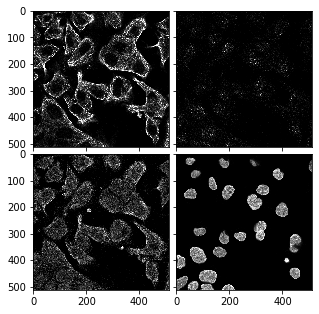

In [28]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(figsize=(5,6))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(2, 2),  
                 axes_pad=0.1, 
                 )
for ax, im in zip(grid, [img1,img2,img3,img4]):
    ax.imshow(im)
plt.show()

In [8]:
# Merging all dataset

if not os.path.exists(OUT_IMG_PATH):
    os.makedirs(OUT_IMG_PATH)
j=0
ids = np.append(annot[annot['Target']=='0'].Id.values, annot[annot['Target']=='25'].Id.values)

for each_id in ids:
    temp_img = open_rgby(IN_IMG_PATH, each_id)
    cv2.imwrite(OUT_IMG_PATH + each_id + '.png', temp_img)
    j += 1
    if j%1000==0:
        print('Finished Merging ' + str(j) + ' images')

shutil.copyfile(DATA_PATH + 'HPIA/train.csv', OUT_PATH + 'train.csv')

Finished Merging 1000 images
Finished Merging 2000 images
Finished Merging 3000 images


'/home/dkube/work/workspace/train.csv'

# After merging

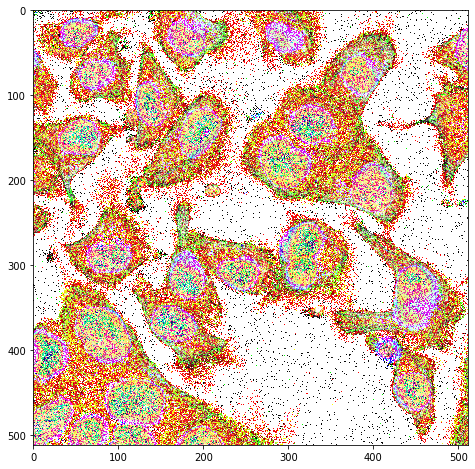

In [29]:
import matplotlib.pyplot as plt
temp_img = open_rgby(IN_IMG_PATH, img_id)
plt.figure(figsize=(8,8))
plt.imshow(temp_img*255)

In [10]:
DATA_DIR = "/home/dkube/work/workspace/"
OUT_DIR = '/home/dkube/work/workspace/split/'
TRAIN_DATA = OUT_DIR + 'train/'
TEST_DATA = OUT_DIR + 'test/'
annot = pd.read_csv(DATA_DIR + 'train.csv')
imgfolder = DATA_DIR + 'Nucleoplasm_Cytosol/'
img_names = os.listdir(imgfolder)
shuffle(img_names)
n_samples = len(img_names)
s_ratio, case = normalize_ratio([90,10], n_samples)
chunks = split_imgs(13, img_names, case)
save_imgs(chunks, imgfolder, [TRAIN_DATA, TEST_DATA], annot)

Train Data Created
Test Data Created


# Annotation

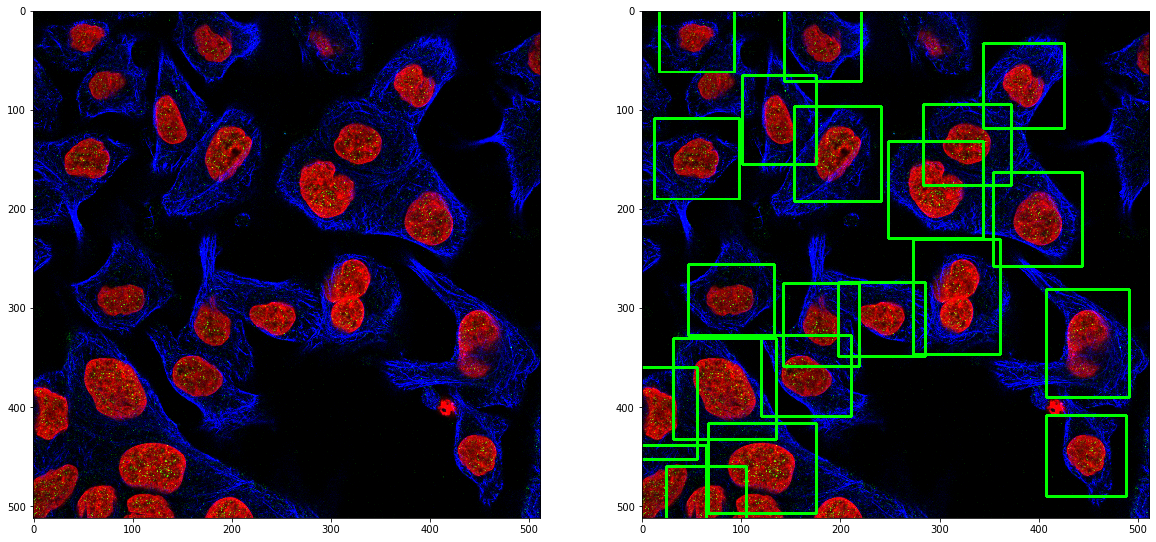

In [18]:
fig = plt.figure(figsize=(20, 15))

img = cv2.imread('/home/dkube/work/workspace/Nucleoplasm_Cytosol/' + img_id + '.png')

img_disp = img[:,:,::-1]
plt.subplot(121)
plt.imshow(img_disp)
    
imCopy = img.copy()
imgray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(imgray, 40, 255, 0)
contours, hierarchy =  cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
sorted_ctrs = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])    
for i, ctr in enumerate(sorted_ctrs):
    x, y, w, h = cv2.boundingRect(ctr)
    roi = img[y:y + h, x:x + w]
    if w > 30 and w < 100 and h > 30 and h < 100:
        cv2.rectangle(imCopy, (x-20, y-20), (x + w + 20, y + h + 20), (0, 255, 0), 2)

plt.subplot(122)
imCopy = imCopy[:,:,::-1]
plt.imshow(imCopy)
plt.show()